In [1]:
!pip install opencv-python
!pip install kaggle
!pip install scikit-learn
!pip install opendatasets

In [2]:
import os
import random
import shutil

import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import opendatasets as od
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import concurrent.futures
import gc
from common import * # Defines the transforms to be applied throughout the investigation

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/alessiocorrado99/animals10'
od.download(dataset_url)

Skipping, found downloaded files in "./animals10" (use force=True to force download)


In [5]:
# Define paths
original_data_dir = 'animals10/raw-img'  # Original dataset directory
train_data_dir = 'animals10-train'  # Destination for training data
test_data_dir = 'animals10-test'  # Destination for test data

# Check if the split has already occurred
if os.path.exists(train_data_dir) and os.path.exists(test_data_dir):
    print("The dataset has already been split into train and test.")
else:
    # Create train and test directories
    os.makedirs(train_data_dir, exist_ok=True)
    os.makedirs(test_data_dir, exist_ok=True)

    # First, determine the smallest class size
    class_sizes = {}
    for class_name in os.listdir(original_data_dir):
        class_path = os.path.join(original_data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_sizes[class_name] = count

    # Find the smallest class size
    min_class_size = min(class_sizes.values())
    test_size_per_class = max(1, min_class_size // 5)  # 20% of the smallest class, ensure at least 1 image for test

    # Iterate through each class directory to split files
    for class_name, count in class_sizes.items():
        class_path = os.path.join(original_data_dir, class_name)
        
        if os.path.isdir(class_path):
            # List all image files in the class directory
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(files)

            # Determine the number of train samples
            train_size = count - test_size_per_class

            # Split files into train and test
            train_files = files[:train_size]
            test_files = files[train_size:train_size + test_size_per_class]

            # Create class directories in train and test folders
            os.makedirs(os.path.join(train_data_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_data_dir, class_name), exist_ok=True)

            # Copy train files
            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_data_dir, class_name, file))

            # Copy test files
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_data_dir, class_name, file))

    # Report the split percentages
    total_train = sum(len(os.listdir(os.path.join(train_data_dir, class_name))) for class_name in os.listdir(train_data_dir))
    total_test = sum(len(os.listdir(os.path.join(test_data_dir, class_name))) for class_name in os.listdir(test_data_dir))

    print(f"Dataset split completed: {total_train} train samples, {total_test} test samples.")
    print(f"Train percentage: {total_train / (total_train + total_test) * 100:.2f}%")
    print(f"Test percentage: {total_test / (total_train + total_test) * 100:.2f}%")


The dataset has already been split into train and test.


In [6]:
# Create the dataloaders

# Create datasets using ImageFolder
train_dataset_unaltered = datasets.ImageFolder(root='animals10-train', transform=unaltered_transforms)
test_dataset_unaltered = datasets.ImageFolder(root='animals10-test', transform=unaltered_transforms)

train_dataset_altered = datasets.ImageFolder(root='animals10-train', transform=altered_transforms)
test_dataset_altered = datasets.ImageFolder(root='animals10-test', transform=altered_transforms)

# Create DataLoaders
train_loader_unaltered = DataLoader(train_dataset_unaltered, batch_size=32, shuffle=True)
test_loader_unaltered = DataLoader(test_dataset_unaltered, batch_size=32, shuffle=False)

train_loader_altered = DataLoader(train_dataset_altered, batch_size=32, shuffle=True)
test_loader_altered = DataLoader(test_dataset_altered, batch_size=32, shuffle=False)

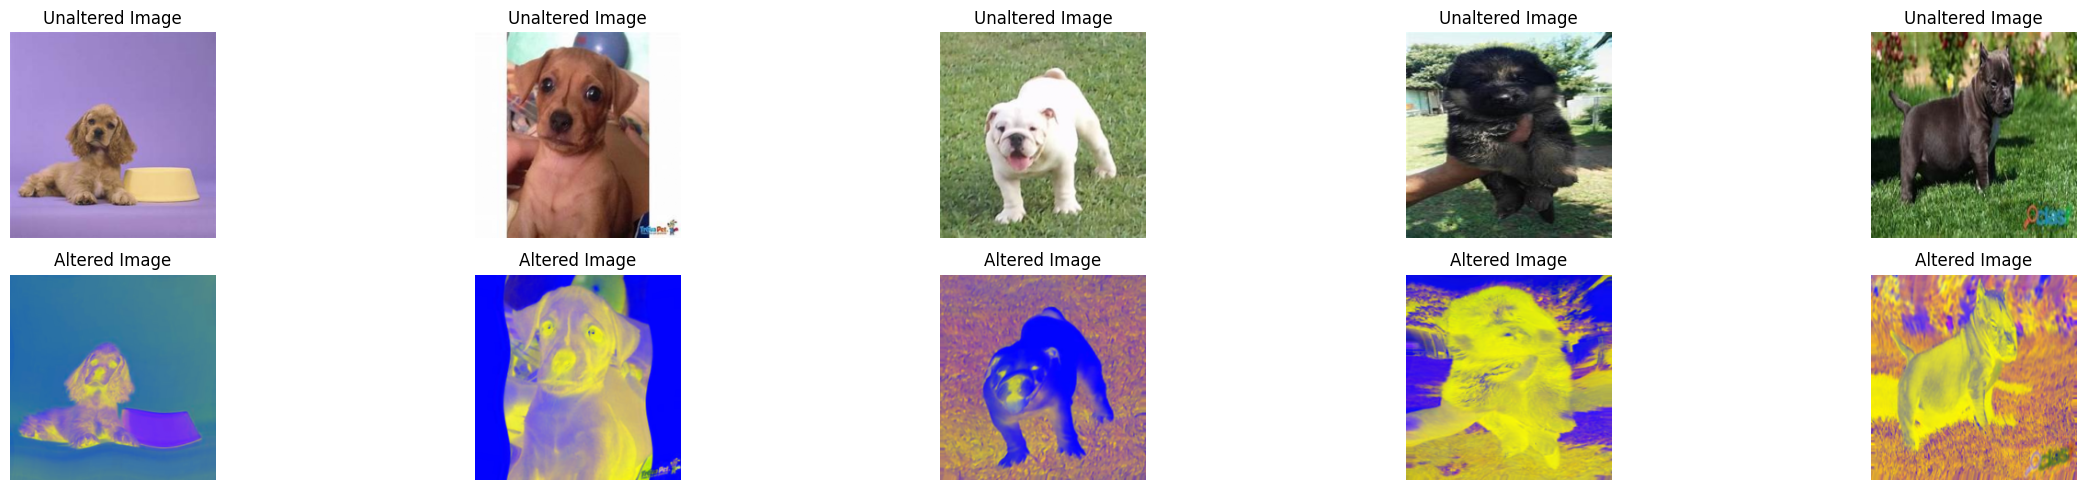

In [7]:
def show_images(loader_unaltered, loader_altered, num_images=5):
    unaltered_iter = iter(loader_unaltered)
    altered_iter = iter(loader_altered)

    # Create subplots: 2 rows (one for unaltered, one for altered), num_images columns
    fig, axes = plt.subplots(2, num_images, figsize=(5 * num_images, 5))

    # Get images and display them
    for i in range(num_images):
        # Get the next images from each loader
        unaltered_images, _ = next(unaltered_iter)
        altered_images, _ = next(altered_iter)

        # Display unaltered image
        axes[0, i].imshow(np.transpose(unaltered_images[0], (1, 2, 0)))
        axes[0, i].set_title('Unaltered Image')
        axes[0, i].axis('off')  # Turn off axis

        # Display altered image
        axes[1, i].imshow(np.transpose(altered_images[0], (1, 2, 0)))
        axes[1, i].set_title('Altered Image')
        axes[1, i].axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function
show_images(test_loader_unaltered, test_loader_altered)


In [8]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the model.

    Parameters:
    - model: The model to train.
    - train_loader: DataLoader for the training data.
    - criterion: Loss function.
    - optimizer: Optimizer for model parameters.
    - device: Device to perform computation ('cpu' or 'cuda').
    - num_epochs: Number of training epochs (default is 10).
    
    Returns:
    - losses: List of average losses per epoch.
    """
    model.to(device)
    losses = []  # List to store loss per epoch

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        # Print statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses


In [9]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move model to the specified device
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [10]:
def get_activations(model, layer_name, dataloader):
    # List to collect activations temporarily
    activations = []

    # Hook function to capture activations
    def hook_fn(module, input_tensor, output):
        activations.append(output.detach().cpu())  # Detach and move to CPU

    # Register the hook to the specified layer
    layer = dict([*model.named_modules()])[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    # Move the model to the specified device
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Run the model on the entire DataLoader
    with torch.no_grad():
        for batch_data, _ in dataloader:
            batch_data = batch_data.to(device)  # Move inputs to the specified device
            model(batch_data)  # Run the model

            # Clear GPU cache after processing each batch
            torch.cuda.empty_cache()

    # Remove the hook
    hook.remove()

    # Concatenate all activations into a single tensor
    all_activations = torch.cat(activations, dim=0) if activations else None
    del activations #hopefully takes care of ram issue
    return all_activations  # Return the concatenated tenso

In [11]:
def compute_grahm(activations):
    """
    Computes the Gram matrix using dot product similarity.
    
    Args:
        activations (torch.Tensor): The input tensor of shape (N, ...),
                                     where N is the batch size and ... represents any number of dimensions.
    
    Returns:
        torch.Tensor: The Gram matrix of shape (N, N).
    """
    # Ensure the activations have at least two dimensions
    if activations.dim() < 2:
        raise ValueError("Input tensor must have at least two dimensions.")

    # Get the shape of the activations
    N = activations.size(0)  # First dimension is the batch size

    # Flatten all dimensions except the first (N)
    flattened_activations = activations.view(N, -1)  # Shape (N, C)

    # Compute the Gram matrix using dot product
    gram_matrix = torch.mm(flattened_activations, flattened_activations.t())  # Shape (N, N)

    return gram_matrix

In [12]:
class Experiment:
    def __init__(self, name, train_loader, test_loader, layers, initialization=None, 
                 do_train=True):
        self.name = name
        self.train_loader = train_loader
        self.do_train = do_train
        self.test_loader = test_loader
        self.layers = layers
        
        # Instantiate the ResNet model
        self.model = models.resnet18(weights=None)
        
        # Modify the final fully connected layer to have 10 outputs
        num_features = self.model.fc.in_features  # Get the input features of the final layer
        self.model.fc = nn.Linear(num_features, 10)  # Replace with a new linear layer with 10 outputs

        if initialization is not None:
            self.model.load_state_dict(initialization)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def runTrain(self,force_retrain=False):
        """
        Runs the training part of the experiment
        """
        print(f"[{self.name}] Running experiment")
        model_weights_filename = f"{self.name}_model.pth"
        loss_filename = f"{self.name}_losses.npy"
    
        if os.path.isfile(model_weights_filename) and (not force_retrain):
            print(f"[{self.name}] Using weights from previous run, to force retrain run with force_retrain=True")
            if (not os.path.isfile(loss_filename)):
                print(f"[{self.name}] WARNING: Could not find per epoch losses for this training run")
            self.model.load_state_dict(torch.load(model_weights_filename, weights_only=True))
        else:
            if self.do_train:
                print(f"[{self.name}] Training model")
                losses = train_model(self.model, self.train_loader, self.criterion, self.optimizer)
                np.save(loss_filename, losses)
                print(f"[{self.name}] Losses saved to {loss_filename}")
            else:
                print(f"[{self.name}] This model specified no training. Weights will be saved for reproducibility")
            torch.save(self.model.state_dict(), model_weights_filename)
            print(f"[{self.name}] Model weights saved to {model_weights_filename}")
    def runEval(self):
        print(f"[{self.name}] Evaluating model performance")
        acc = evaluate_model(self.model, self.test_loader)
        print(f"[{self.name}] Accuracy: {acc:.2f}%")
        confusion_matrix_filename = f"{self.name}_confusion_matrix.csv"
        # Compute confusion matrix
        all_labels = []
        all_preds = []
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        np.save(confusion_matrix_filename, cm)
        print(f"[{self.name}] Confusion matrix saved to {confusion_matrix_filename}")

        for layername in self.layers:
            print(f"[{self.name}] Computing gram matrix for layer {layername}...")
    
            activations = get_activations(self.model, layername, self.test_loader)
            print(f"[{self.name}] Activations for {layername} gathered.")
    
            grahm = compute_grahm(activations)
            print(f"[{self.name}] Graham computed for {layername}. Cleaning up.")
            del activations
            
            # Convert to NumPy array if needed
            if isinstance(grahm, torch.Tensor):
                grahm = grahm.cpu().detach().numpy()
            gc.collect()
            # Save the Graham matrix as a NumPy array
            np.save(f"{self.name}_{layername}_grahmian.npy", grahm)
    
    def run(self, force_retrain=False):
        self.runTrain(force_retrain)
        self.runEval()

def run_experiment(experiment):
    experiment.run()
def run_experiment_train(experiment):
    experiment.runTrain()

In [13]:
torch.manual_seed(42)
# Create 'baseline' untrained model to extract weights
baseline_model = models.resnet18(weights=None)
num_features = baseline_model.fc.in_features  # Get the input features of the final layer
baseline_model.fc = nn.Linear(num_features, 10)  # Replace with a new linear layer with 10 outputs
# Extract the weights from the baseline model
initialization_weights = baseline_model.state_dict()
weights = baseline_model.state_dict()

observed_layers = ["layer2","layer4","fc"]

experiments = [
    Experiment(
        name="unaltered_noinit",
        train_loader=train_loader_unaltered,
        test_loader=test_loader_unaltered,
        layers=observed_layers,
    ),
    Experiment(
        name="altered_noinit",
        train_loader=train_loader_altered,
        test_loader=test_loader_altered,
        layers=observed_layers,
    ),
    Experiment(
        name="unaltered_init",
        train_loader=train_loader_unaltered,
        test_loader=test_loader_unaltered,
        layers=observed_layers,
        initialization=weights
    ),
    Experiment(
        name="altered_init",
        train_loader=train_loader_altered,
        test_loader=test_loader_altered,
        layers=observed_layers,
        initialization=weights      
    ),
    Experiment(
        name="altered_init",
        train_loader=train_loader_altered,
        test_loader=test_loader_altered,
        layers=observed_layers,
        initialization=weights      
    ),
    Experiment(
        name="altered_notrain",
        train_loader=train_loader_altered,
        test_loader=test_loader_altered,
        layers=observed_layers,
        do_train=False
    ),
    Experiment(
        name="unaltered_notrain",
        train_loader=train_loader_unaltered,
        test_loader=test_loader_unaltered,
        layers=observed_layers,
        do_train=False
    ),
]

for i in experiments:
    i.run()

[unaltered_noinit] Running experiment
[unaltered_noinit] Training model
Epoch [1/10], Loss: 1.6754
Epoch [2/10], Loss: 1.2104
Epoch [3/10], Loss: 0.9872
Epoch [4/10], Loss: 0.8227
Epoch [5/10], Loss: 0.6892
Epoch [6/10], Loss: 0.5687
Epoch [7/10], Loss: 0.4561
Epoch [8/10], Loss: 0.3444
Epoch [9/10], Loss: 0.2499
Epoch [10/10], Loss: 0.1782
[unaltered_noinit] Losses saved to unaltered_noinit_losses.npy
[unaltered_noinit] Model weights saved to unaltered_noinit_model.pth
[unaltered_noinit] Evaluating model performance
[unaltered_noinit] Accuracy: 71.25%
[unaltered_noinit] Confusion matrix saved to unaltered_noinit_confusion_matrix.csv
[unaltered_noinit] Computing gram matrix for layer layer2...
[unaltered_noinit] Activations for layer2 gathered.
[unaltered_noinit] Graham computed for layer2. Cleaning up.
[unaltered_noinit] Computing gram matrix for layer layer4...
[unaltered_noinit] Activations for layer4 gathered.
[unaltered_noinit] Graham computed for layer4. Cleaning up.
[unaltered_n

In [14]:
def count_samples_in_subfolders(base_directory):
    """Counts the number of samples in each subfolder of the given directory."""
    # Iterate through each item in the base directory
    for subfolder in os.listdir(base_directory):
        subfolder_path = os.path.join(base_directory, subfolder)
        
        # Check if the item is a directory
        if os.path.isdir(subfolder_path):
            # Count the number of files in the subfolder
            sample_count = len([file for file in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, file))])
            print(f"{subfolder}: {sample_count} samples")

# Specify the base directory you want to analyze
base_directory = "./animals10-test"  # Change this to your directory path

# Call the function to count samples
count_samples_in_subfolders(base_directory)

pecora: 289 samples
cane: 289 samples
farfalla: 289 samples
gatto: 289 samples
gallina: 289 samples
ragno: 289 samples
scoiattolo: 289 samples
cavallo: 289 samples
mucca: 289 samples
elefante: 289 samples
